In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

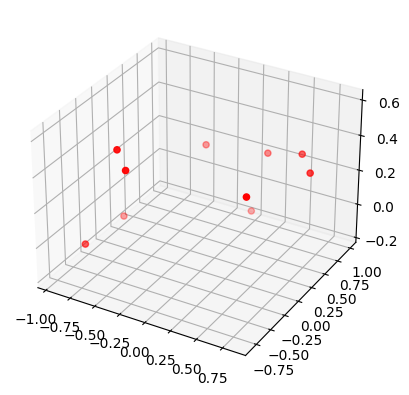

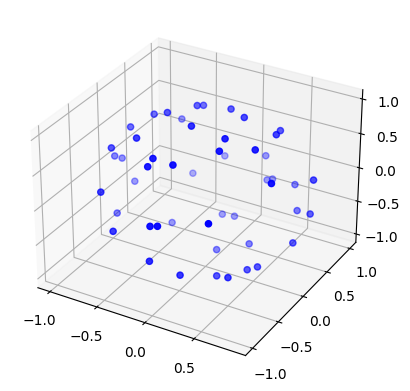

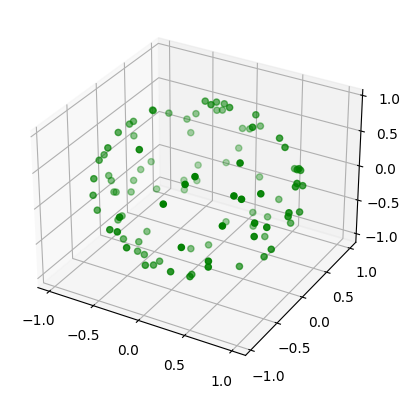

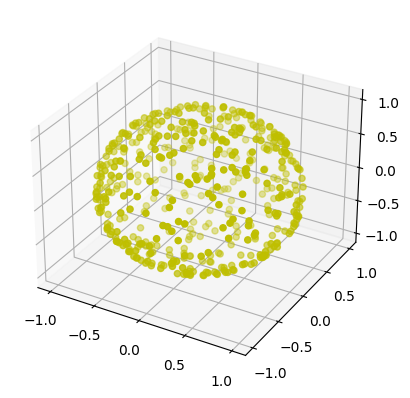

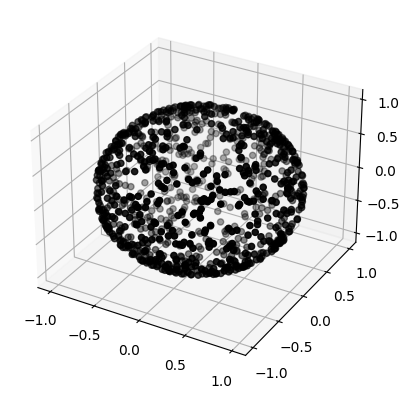

In [2]:
# Source How to generate equidistributed points on the surface of a sphere -- https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf
# Randomly generate 100 points on a sphere
# Radius = 1
# Center = (0,0,0)

def samples(n):
    # Generating z coordinates with radius = 1
    z = np.random.uniform(-1,1,n)

    # Generating azimuthal angles
    phi = np.random.uniform(0,2*math.pi,n)

    # Generating x and y coordinates
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    samples = np.array([x,y,z]).T
    return samples

# Generating samples with n = 10, 50, 100, 500, 1000
data10 = samples(10)
data50 = samples(50)
data100 = samples(100)
data500 = samples(500)
data1000 = samples(1000)

# Plotting the points
fig1, fig2, fig3, fig4, fig5 = plt.figure(), plt.figure(), plt.figure(), plt.figure(), plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111, projection='3d')
ax3 = fig3.add_subplot(111, projection='3d')
ax4 = fig4.add_subplot(111, projection='3d')
ax5 = fig5.add_subplot(111, projection='3d')
ax1.scatter(data10[:,0], data10[:,1], data10[:,2], c='r', marker='o')
ax2.scatter(data50[:,0], data50[:,1], data50[:,2], c='b', marker='o')
ax3.scatter(data100[:,0], data100[:,1], data100[:,2], c='g', marker='o')
ax4.scatter(data500[:,0], data500[:,1], data500[:,2], c='y', marker='o')
ax5.scatter(data1000[:,0], data1000[:,1], data1000[:,2], c='k', marker='o')
plt.show()


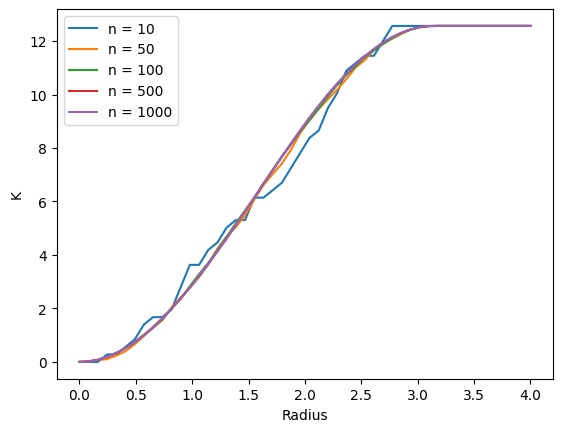

In [3]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf

def distance(r,vec1,vec2):
    # pythagorean theorem
    # d = math.sqrt((vec2[0]-vec1[0])**2 + (vec2[1]-vec1[1])**2 + (vec2[2]-vec1[2])**2)
    d = np.linalg.norm(vec1-vec2)
    # Arc Distance
    dist = r * 2* math.asin(d/2)
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            #dist.append(distance(r, data[i, 0], data[i, 1], data[i, 2], data[j, 0], data[j, 1], data[j, 2]))
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

radii = np.linspace(0, 4, 50)

kt10 = ripleyK(1, data10, radii)
kt50 = ripleyK(1, data50, radii)
kt100 = ripleyK(1, data100, radii)
kt500 = ripleyK(1, data500, radii)
kt1000 = ripleyK(1, data1000, radii)

# Plotting the Ripley's K function
plt.plot(radii, kt10, label='n = 10')
plt.plot(radii, kt50, label='n = 50')
plt.plot(radii, kt100, label='n = 100')
plt.plot(radii, kt500, label='n = 500')
plt.plot(radii, kt1000, label='n = 1000')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()

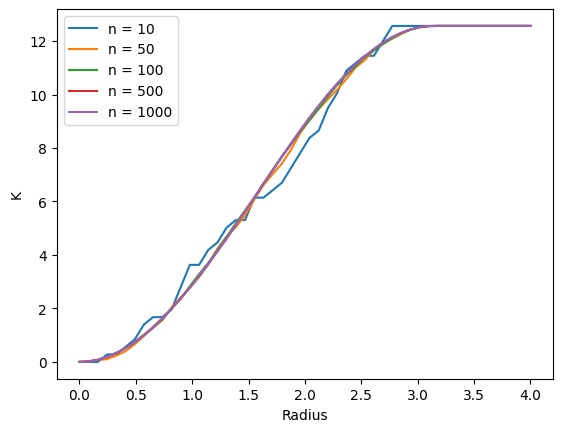

In [5]:
# distance between two points on a sphere 
# https://www.cuemath.com/trigonometry/trigonometric-table/
# Source: https://www.math.ksu.edu/~dbski/writings/haversine.pdf

def distance(radii,vec1,vec2):
    dist = radii * abs(math.acos(np.dot(vec1, vec2)/radii**2))
    return dist

def pairDistances(r, data):
    npts = np.shape(data)[0]
    dist = []
    for i in range(npts):
        for j in range(i+1, npts):
            dist.append(distance(r, data[i], data[j]))
    return dist

# Calculating the distance between all pairs of points
def surfaceArea(r):
    area = 4 * math.pi * r**2
    return area


def ripleyK(r, data, radii):
    K = np.zeros_like(radii)
    area = surfaceArea(r)
    dist = pairDistances(r, data)
    pair_num = len(dist)
    intensity = pair_num / area
    for i in range(len(radii)):
        K[i] = np.sum(dist < radii[i])
    K = K / intensity
    return K

radii = np.linspace(0, 4, 50)

# Plotting the Ripley's K function
plt.plot(radii, kt10, label='n = 10')
plt.plot(radii, kt50, label='n = 50')
plt.plot(radii, kt100, label='n = 100')
plt.plot(radii, kt500, label='n = 500')
plt.plot(radii, kt1000, label='n = 1000')
plt.xlabel('Radius')
plt.ylabel('K')
plt.legend()
plt.show()